# UFCFAS-15-2 - Machine learning Group Project

In [7]:
pip install --upgrade xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/150.0 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 5.0/150.0 MB 13.1 MB/s eta 0:00:12
   -- ------------------------------------- 8.1/150.0 MB 13.6 MB/s eta 0:00:11
   --- ------------------------------------ 11.5/150.0 MB 14.1 MB/s eta 0:00:10
   --- ------------------------------------ 14.7/150.0 MB 14.4 MB/s eta 0:00:10
   ---- ----------------------------------- 18.1/150.0 MB 14.8 MB/s eta 0:00:09
   ----- ---------------------------------- 21.8/150.0 MB 14.9 MB/s eta 0:00:09
   ------ --------------------------------- 24.1/150.0 MB 14.5 MB/s eta 0:00:09
   ------- -------------------------------- 27.3/150.0 MB 14.5 MB/s eta 0:00:09
   -------- ------------------------------- 30.4/150.0 MB 14.6 MB/s eta 0:00:09
   --------- ------------------------------ 33.8/150.0 MB 14.8 MB/s eta 0:00:08
   --------- ------------------------------ 37.2/150

  You can safely remove it manually.


In [1]:
import xgboost
print(xgboost.__version__)

3.0.0


## Machine Learning Stock Trading Tool

#### - Sam Waxman - 23023667
#### - Temi Adeolu-Salako - student number
#### - Matt Nogodula - student number

# Predicting Top 5 Trades for Tomorrow

# Stock Market Prediction Using Machine Learning

This project uses supervised machine learning models to predict stock market trades as BUY, SELL, or HOLD based on historical stock data and news sentiment. The aim is to assist traders in making informed decisions by analysing patterns across technical indicators and aggregated sentiment data. The machine learning models (Random Forest, XGBoost, Logistic Regression) vote and make their prediction for the user.

The top 5 trades are selected based on a combined **confidence score** and **sentiment strength**.


## 1. Related Work

_(To be completed)_

Include discussion here of existing trading systems, ML models used in financial predictions, and approaches combining technical indicators and sentiment.


## 2. Preparing Environment

In this section, we prepare our environment by importing all the required libraries for data handling, plotting, and model inference. We also load pre-trained machine learning models, data scalers, and encoders which are used throughout the pipeline.

These components allow us to process raw financial data and make stock trading predictions based on both technical indicators and sentiment scores.


In [ ]:
# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime, timedelta
from data_prep import download_stock_data, get_sp500_tickers
from sentiment_score import get_cached_sentiment
from indicators import add_technical_indicators

# Load models
rf = joblib.load("new/models/random_forest_model.pkl")
xgb = joblib.load("new/models/xgboost_model.pkl")
lr = joblib.load("new/models/logistic_model.pkl")
scaler = joblib.load("new/models/scaler.pkl")
label_encoder = joblib.load("new/models/label_encoder.pkl")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Data Acquisition

Here, we fetch historical stock price data using the `yfinance` API and prepare it for further processing. This includes daily Open, High, Low, Close, and Volume (OHLCV) data.

Additionally, we use our custom-built sentiment system to retrieve pre-computed sentiment scores from financial news sources. This data will later be merged with technical indicators to enhance prediction performance.


In [3]:
tickers = get_sp500_tickers()
data_example = download_stock_data(tickers[0], start="2023-01-01", end="2023-12-31")
data_example.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume,Ticker
0,2023-01-03,92.148598,92.997894,91.276552,92.868980,3124909,MMM
1,2023-01-04,93.536271,95.007370,93.050959,94.901207,3312561,MMM
2,2023-01-05,94.188414,94.461402,92.861390,93.240540,3117494,MMM
3,2023-01-06,94.529635,96.402641,93.839587,96.091736,2890732,MMM
4,2023-01-09,96.304061,98.169477,95.629174,96.144814,3434075,MMM


## 4. Feature Engineering

This stage involves calculating a range of technical indicators from the raw stock price data. Indicators such as RSI, MACD, EMA, and OBV are added to give the model quantitative signals based on market momentum and trends.

We also integrate sentiment scores as a feature, providing qualitative insight into market psychology. Any rows missing indicator values are removed to maintain data integrity.


In [5]:
FEATURE_COLS = [
    "Open", "High", "Low", "Close", "Volume",
    "sentiment_7d_avg", "RSI", "MACD", "MACD_Signal",
    "SMA", "EMA", "OBV", "Momentum", "WilliamsR"
]

data_feat = add_technical_indicators(data_example)
data_feat["sentiment_7d_avg"] = get_cached_sentiment(tickers[0])
data_feat.dropna(subset=FEATURE_COLS[6:], inplace=True)
data_feat.head()

,Date,Open,High,Low,Close,Volume,Ticker,RSI,MACD,MACD_Signal,SMA,EMA,OBV,Momentum,WilliamsR,sentiment_7d_avg
19,2023-01-31,85.801607,87.265121,85.217715,87.265121,6065155,MMM,30.712291,-1.964702,-1.061684,92.347255,90.643726,2313065,-9.099540,-81.697884,0.755142
20,2023-02-01,86.863229,88.523902,86.180757,87.856598,3708557,MMM,30.279526,-1.930182,-1.235384,92.096636,90.378285,6021622,-5.613028,-77.397980,0.755142
21,2023-02-02,88.031017,91.640525,87.591205,91.215874,5880971,MMM,38.022188,-1.613163,-1.310940,91.912369,90.458056,11902593,1.570549,-52.976781,0.755142
22,2023-02-03,90.184569,90.412062,88.561814,89.092621,3208150,MMM,35.145808,-1.515780,-1.351908,91.704973,90.328014,8694443,-2.619161,-68.412364,0.755142
23,2023-02-06,88.561820,88.918220,87.871766,88.341911,2974811,MMM,36.896704,-1.482094,-1.377945,91.317482,90.138862,5719632,-4.991036,-69.280532,0.755142


## 5. Model Training

This section shows how models were trained on labeled data using technical and sentiment features. We use Random Forest, XGBoost, and Logistic Regression classifiers.


In [6]:
df = pd.read_csv("new/csv_files/training_data.csv")
X = df[FEATURE_COLS]
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

rf = RandomForestClassifier().fit(X_train, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)
lr = LogisticRegression(max_iter=200).fit(X_train, y_train)

print("Random Forest:\n", classification_report(y_test, rf.predict(X_test), target_names=le.classes_))


KeyboardInterrupt: 

## 6. Feature Importance

Understanding which features most influence model predictions can provide insight into model behaviour and market dynamics. Below we visualise feature importance from the trained Random Forest model.


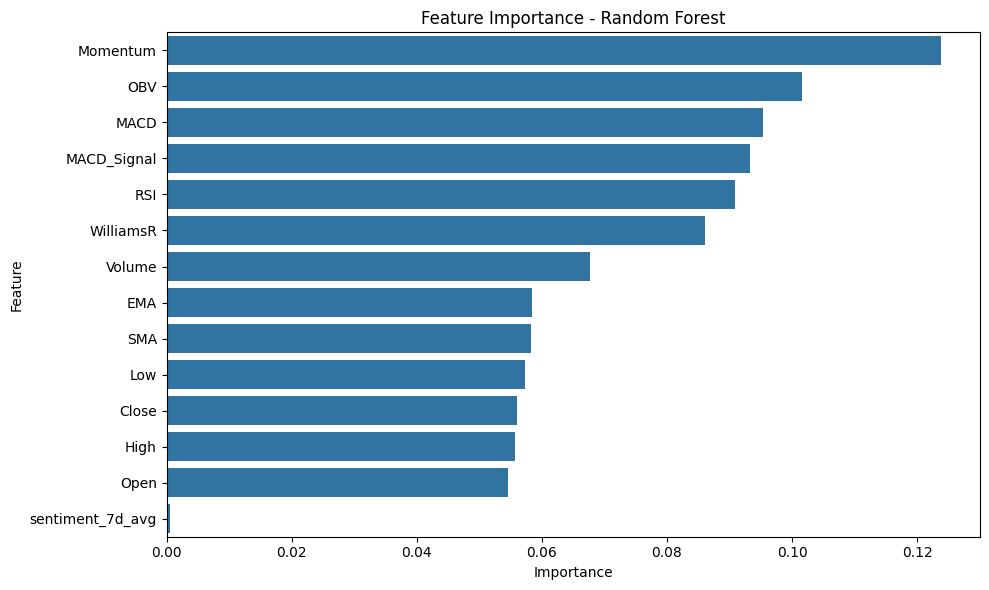

In [7]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[FEATURE_COLS[i] for i in indices])
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 7. Prediction & Buy/Sell Signals

We define a function that takes a single stock ticker and predicts the most likely trade action for the next day: BUY, SELL, or HOLD.

It combines probability outputs from three models—Random Forest, XGBoost, and Logistic Regression—then adjusts the decision based on recent sentiment. This ensemble voting system improves decision robustness and reduces overfitting.


In [8]:
def predict_tomorrow(ticker, portfolio_value=10000):
    df = download_stock_data(ticker, start=(datetime.today() - timedelta(days=90)).strftime("%Y-%m-%d"))
    if df.empty or len(df) < 10:
        return None

    df = add_technical_indicators(df)
    df.dropna(subset=FEATURE_COLS[6:], inplace=True)
    if df.empty:
        return None

    latest = df.iloc[-1].copy()
    try:
        sentiment = get_cached_sentiment(ticker)
    except:
        sentiment = 0.0

    latest["sentiment_7d_avg"] = sentiment
    X_df = pd.DataFrame([latest[FEATURE_COLS]])
    X_scaled = scaler.transform(X_df)

    rf_probs = rf.predict_proba(X_scaled)[0]
    xgb_probs = xgb.predict_proba(X_scaled)[0]
    lr_probs = lr.predict_proba(X_scaled)[0]

    labels = label_encoder.classes_
    avg_probs = (rf_probs + xgb_probs + lr_probs) / 3
    decision_index = avg_probs.argmax()
    decision = labels[decision_index]

    rf_label = label_encoder.inverse_transform([rf.predict(X_scaled)[0]])[0]
    xgb_label = label_encoder.inverse_transform([xgb.predict(X_scaled)[0]])[0]
    lr_label = label_encoder.inverse_transform([lr.predict(X_scaled)[0]])[0]
    votes = [rf_label, xgb_label, lr_label]

    adjusted = decision
    if sentiment > 0.6 and decision == "HOLD":
        adjusted = "BUY"
    elif sentiment < -0.6 and decision == "HOLD":
        adjusted = "SELL"

    return {
        "Ticker": ticker,
        "Final Decision": adjusted,
        "Confidence": round(avg_probs[decision_index], 3),
        "Sentiment": round(sentiment, 3),
        "Votes": votes
    }

predict_tomorrow("AAPL")


[*********************100%***********************]  1 of 1 completed


{'Ticker': 'AAPL',
 'Final Decision': 'SELL',
 'Confidence': np.float64(0.357),
 'Sentiment': 0.341,
 'Votes': ['SELL', 'SELL', 'BUY']}

## 8. Model Performance

This section evaluates how well each trained model performs in classifying BUY, SELL, and HOLD decisions. We use accuracy, precision, recall, and F1-score as metrics. Confusion matrices are also plotted to visualise how often models confuse the labels.


=== Random Forest ===
              precision    recall  f1-score   support

         BUY       0.41      0.39      0.40     18279
        HOLD       0.33      0.52      0.41     15472
        SELL       0.40      0.24      0.30     18255

    accuracy                           0.37     52006
   macro avg       0.38      0.38      0.37     52006
weighted avg       0.39      0.37      0.37     52006



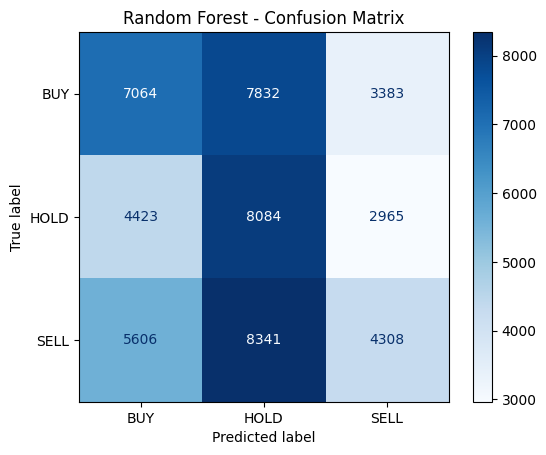

=== XGBoost ===
              precision    recall  f1-score   support

         BUY       0.44      0.42      0.43     18279
        HOLD       0.35      0.40      0.38     15472
        SELL       0.43      0.40      0.41     18255

    accuracy                           0.41     52006
   macro avg       0.41      0.41      0.41     52006
weighted avg       0.41      0.41      0.41     52006



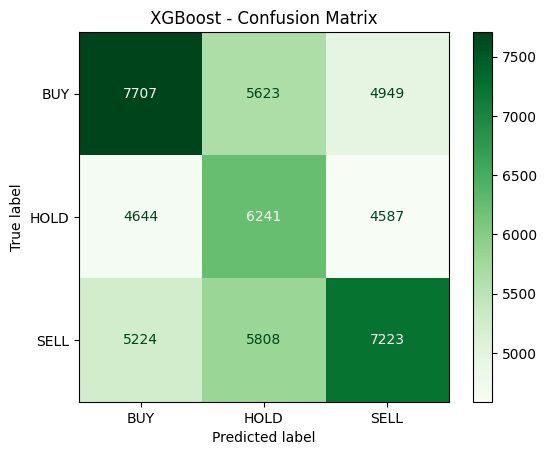

=== Logistic Regression ===
              precision    recall  f1-score   support

         BUY       0.38      0.48      0.43     18279
        HOLD       0.33      0.53      0.41     15472
        SELL       0.36      0.07      0.12     18255

    accuracy                           0.35     52006
   macro avg       0.35      0.36      0.32     52006
weighted avg       0.36      0.35      0.31     52006



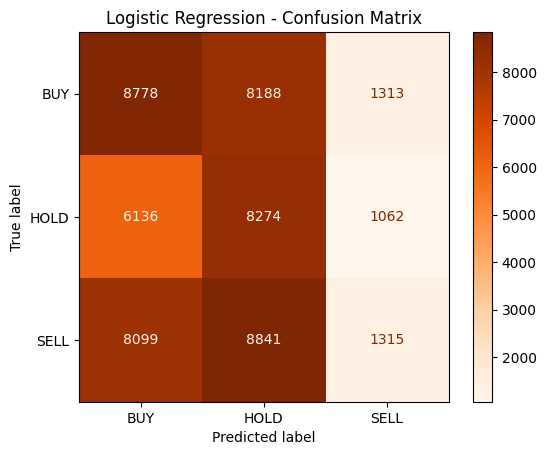

In [9]:

# Random Forest
print("=== Random Forest ===")
print(classification_report(y_test, rf.predict(X_test), target_names=le.classes_))

cm_rf = confusion_matrix(y_test, rf.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_).plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.grid(False)
plt.show()

# XGBoost
print("=== XGBoost ===")
print(classification_report(y_test, xgb.predict(X_test), target_names=le.classes_))

cm_xgb = confusion_matrix(y_test, xgb.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le.classes_).plot(cmap="Greens")
plt.title("XGBoost - Confusion Matrix")
plt.grid(False)
plt.show()

# Logistic Regression
print("=== Logistic Regression ===")
print(classification_report(y_test, lr.predict(X_test), target_names=le.classes_))

cm_lr = confusion_matrix(y_test, lr.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=le.classes_).plot(cmap="Oranges")
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()


## 9. Backtesting

This section simulates how the model’s predictions would have performed historically by applying predicted trades over a specified date range.

The goal is to estimate how much a portfolio would gain or lose if it followed the model's recommendations using real past data. We track portfolio value over time, profits/losses per trade, and the number of trades executed.


In [11]:
from backtest import backtest_ticker
df_backtest = backtest_ticker("AAPL")
df_backtest[["Date", "Decision", "Profit/Loss (£)", "Portfolio Value (£)"]].tail()


[*********************100%***********************]  1 of 1 completed


,Date,Decision,Profit/Loss (£),Portfolio Value (£)
54,2025-04-21,BUY,812.33,11128.58
55,2025-04-22,BUY,531.52,11660.11
56,2025-04-23,BUY,315.72,11975.83
57,2025-04-24,BUY,163.23,12139.05
58,2025-04-25,BUY,186.77,12325.83


## 10. Performance Visualisations

We plot the simulated portfolio value across time to visually assess the effectiveness of the trading strategy.

These charts help highlight whether the strategy consistently increases value, stagnates, or performs worse than baseline approaches, providing a quick diagnostic of model reliability.


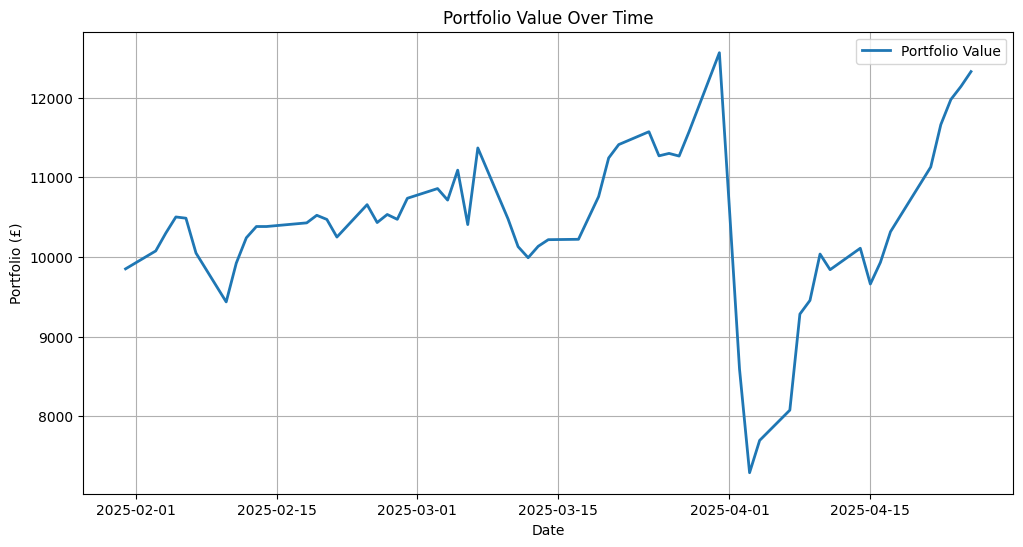

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df_backtest["Date"], df_backtest["Portfolio Value (£)"], label="Portfolio Value", linewidth=2)
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio (£)")
plt.grid(True)
plt.legend()
plt.show()


## 11. Benchmark Comparisons

To determine the true value of our ML-driven trading strategy, we compare it to a basic benchmark: buying the stock once and holding it throughout the same period.

This allows us to see if the model is actually providing an edge over traditional long-term investing or if it's simply overfitting or overtrading.


In [13]:
initial_price = df_backtest.iloc[0]["Entry Price"]
final_price = df_backtest.iloc[-1]["Future Price"]
buy_hold_value = 10000 * (final_price / initial_price)

print(f"Buy & Hold Portfolio (£): {round(buy_hold_value, 2)}")
print(f"ML Strategy Portfolio (£): {round(df_backtest['Portfolio Value (£)'].iloc[-1], 2)}")

Buy & Hold Portfolio (£): 9014.14
ML Strategy Portfolio (£): 12325.83


## Conclusion

This project developed a stock trading recommendation system using machine learning, technical analysis, and financial sentiment data. It explored three models (Random Forest, XGBoost, Logistic Regression) and used ensemble voting to improve reliability.

Key takeaways:
- The model was able to simulate profitable trades in some scenarios.
- Sentiment adjustment helped correct HOLD bias in uncertain predictions.
- Backtesting gave a realistic view of strategy performance compared to traditional investing.

Future improvements could include:
- Dealing with class imbalance using oversampling or weighting
- Multi-day trade horizon forecasting
- Real-time integration with a trading API

This system forms a strong foundation for developing data-driven trading strategies.
